In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np

## Read in Data

### Transaction

In [ ]:
transaction = pd.read_csv("train_transaction.csv")
transaction_data = transaction.copy()


### Identity

In [ ]:
identity = pd.read_csv("train_identity.csv")
identity_data = identity.copy()


### Function to inspect and analyze dataset

In [34]:
import pandas as pd
import numpy as np

def analyze_unknown_columns(df):
    """
    column analysis function translated from R
    """
    analysis_data = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Basic info
        col_type = col_data.dtype
        na_percent = round(col_data.isna().mean() * 100, 2)
        unique_values = col_data.nunique()
        
        # Min/Max for numeric columns
        if np.issubdtype(col_type, np.number):
            if col_data.notna().any():
                min_val = round(col_data.min(), 2)
                max_val = round(col_data.max(), 2)
            else:
                min_val = "All NA"
                max_val = "All NA"
        else:
            min_val = "N/A"
            max_val = "N/A"
        
        # Sample values (first 5 non-null unique values)
        sample_vals = col_data.dropna().unique()[:5]
        sample_str = ", ".join(str(x) for x in sample_vals)
        
        analysis_data.append({
            'column': col,
            'type': col_type,
            'na_percent': na_percent,
            'unique_values': unique_values,
            'min_value': min_val,
            'max_value': max_val,
            'sample_values': sample_str
        })
    
    # Create analysis DataFrame
    column_analysis = pd.DataFrame(analysis_data)
    
    print("=== AUTOMATED COLUMN ANALYSIS ===")
    pd.set_option('display.max_rows', None)
    print(column_analysis)
    pd.reset_option('display.max_rows')
    
    return column_analysis



In [ ]:
#check memory usage

memory_mb = transaction_data.memory_usage(deep=True).sum() / 1024**2
print(f"Total memory: {memory_mb:.2f} MB")

Total memory: 1771.84 MB


In [33]:
#  analyze Usage
#column_info = analyze_unknown_columns(transaction_data)

### Handle Missing Data, impute for numeric columns

In [32]:
def handle_missing_columns(df, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=None):
    """
    Optimized version that avoids fragmentation by collecting all indicators first.

    
    Create missingness indicators for columns with NA fraction >= missing_threshold.
    Drop original columns if NA fraction >= drop_threshold.
    Impute mean for numeric columns that are kept.
    encode categorical columns

    Parameters:
        df: DataFrame
        missing_threshold: create indicators for columns with NA >= this fraction
        drop_threshold: drop original columns if NA >= this fraction
        exclude_cols: list of columns not to modify (e.g., target, ID)

    Returns:
        df_copy: cleaned DataFrame
        dropped_cols: list of original columns that were dropped
    """

    df = df.copy()  # protect original

    if exclude_cols is None:
        exclude_cols = []

    cols = [c for c in df.columns if c not in exclude_cols]
    dropped_cols = []
    
    # Step 1: Create missing indicators for ALL columns above missing_threshold
    cols_for_indicators = []
    for col in cols:
        na_frac = df[col].isna().mean()
        if na_frac >= missing_threshold:
            cols_for_indicators.append(col)
    
    # Create all indicators at once
    if cols_for_indicators:
        missing_indicators = {}
        for col in cols_for_indicators:
            missing_indicators[f"{col}_missing"] = df[col].isna().astype(np.int8)
        
        indicators_df = pd.DataFrame(missing_indicators, index=df.index)
        df = pd.concat([df, indicators_df], axis=1)

    # Step 2: Now drop columns above drop_threshold
    cols_to_drop = []
    for col in cols:
        na_frac = df[col].isna().mean()
        if na_frac >= drop_threshold:
            cols_to_drop.append(col)
    
    df.drop(columns=cols_to_drop, inplace=True)
    dropped_cols = cols_to_drop.copy()
        
    
    # Step 3: Impute numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [c for c in numeric_cols if not c.endswith("_missing")]
    
    for col in numeric_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mean())

    # Step 4: Handle categorical columns using tree-friendly preprocessing
    cat_cols = df.select_dtypes(include=['object']).columns
    
    # Binary columns (2 unique values, excluding NaN)
    binary_cols = [c for c in cat_cols if df[c].nunique(dropna=True) == 2]
    # Small multi-category columns (3–10 unique values)
    small_cat_cols = [c for c in cat_cols if 3 <= df[c].nunique(dropna=True) <= 10]
    # High-cardinality columns (>10 unique values)
    high_card_cols = [c for c in cat_cols if df[c].nunique(dropna=True) > 10]

    # --- Binary columns ---
    for col in binary_cols:
        vals = df[col].dropna().unique()
        mapping = {vals[0]: 0, vals[1]: 1}
        # Simply map and fill missing with -1
        df[col] = df[col].map(mapping).fillna(-1)

    # --- Small multi-category columns ---
    if small_cat_cols:
        df = pd.get_dummies(df, columns=small_cat_cols, dummy_na=True, drop_first=False)

    # --- High-cardinality columns ---
    for col in high_card_cols:
        freq = df[col].value_counts(dropna=False)
        df[col + "_freq"] = df[col].map(freq)
        df.drop(columns=[col], inplace=True)
    
    return df, dropped_cols

In [ ]:
exclude = ["TransactionID", "isFraud"]

train_transaction_clean, dropped_cols = handle_missing_columns(
    transaction_data, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=exclude
)

print("Dropped columns:", dropped_cols)

Dropped columns: ['dist2']


In [ ]:
#check memory usage

memory_mb = transaction_data.memory_usage(deep=True).sum() / 1024**2
print(f"Total memory: {memory_mb:.2f} MB")

Total memory: 1771.84 MB


In [ ]:
exclude = ["TransactionID", "isFraud"]

train_identity_clean, dropped_cols = handle_missing_columns(
    identity_data, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=exclude
)

In [ ]:
## List of Matching TransactionIDs
merged_df = pd.merge(train_identity_clean, train_transaction_clean, on='TransactionID', how='left')

overlapping_ids = train_identity_clean['TransactionID'].tolist()


#Random forest


In [ ]:
# Fraud Detection with Random Forest

## Data Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned and merged data
X = merged_df.drop(columns=["isFraud"])
y = merged_df["isFraud"]

## Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7406
)

# If you want to compare with transaction-only data (like in your LGBM code):
# transaction_subset = train_transaction_clean[train_transaction_clean['TransactionID'].isin(overlapping_ids)]
# X_transaction = transaction_subset.drop(columns=["isFraud"])
# y_transaction = transaction_subset["isFraud"]
# X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_transaction, y_transaction, test_size=0.2, stratify=y_transaction, random_state=7406)

## Random Forest Model Function
def RandomForest(X_train, X_test, y_train, y_test):
    """
    Random Forest equivalent of your LGBM function
    """
    # Handle categorical columns - RF needs encoding
    object_columns = X_train.select_dtypes(include=['object']).columns
    if len(object_columns) > 0:
        print(f"Encoding {len(object_columns)} categorical columns for Random Forest")
        # Simple label encoding for categorical columns
        for col in object_columns:
            X_train[col] = X_train[col].astype('category').cat.codes
            X_test[col] = X_test[col].astype('category').cat.codes
    
    # Random Forest parameters optimized for fraud detection
    rf_model = RandomForestClassifier(
        n_estimators=100,           # Number of trees
        max_depth=15,               # Control tree depth to prevent overfitting
        min_samples_split=50,       # Minimum samples to split
        min_samples_leaf=20,        # Minimum samples per leaf
        max_features='sqrt',        # Feature sampling
        class_weight='balanced',    # Handle imbalanced data
        random_state=7406,
        n_jobs=-1                  # Use all cores
    )
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predict probabilities
    pred_rf = rf_model.predict_proba(X_test)[:, 1]
    pr_auc_rf = average_precision_score(y_test, pred_rf)
    
    return pr_auc_rf, rf_model

## Run Random Forest on your merged data
rf_auc, rf_model = RandomForest(X_train, X_test, y_train, y_test)
print(f"Random Forest PR AUC for Combined Data: {rf_auc:.4f}")

## Cross-Validation for Random Forest
def CV_RandomForest(X_train, y_train, n_splits=5):
    """
    Cross-validation equivalent for Random Forest
    """
    # Sample for faster computation (like your LGBM CV)
    X_sample = X_train.sample(frac=0.25, random_state=7406)
    y_sample = y_train.loc[X_sample.index]
    
    cv_results = {}
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7406)
    aucs = []
    
    # Handle categorical columns for the entire sample first
    object_columns = X_sample.select_dtypes(include=['object']).columns
    if len(object_columns) > 0:
        for col in object_columns:
            X_sample[col] = X_sample[col].astype('category').cat.codes
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_sample, y_sample)):
        print(f"  Fold {fold + 1}", end=" - ")
        
        X_fold_train, X_fold_val = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
        y_fold_train, y_fold_val = y_sample.iloc[train_idx], y_sample.iloc[val_idx]
        
        # Random Forest model
        rf_model = RandomForestClassifier(
            n_estimators=50,           # Fewer trees for CV speed
            max_depth=15,
            min_samples_split=50,
            min_samples_leaf=20,
            max_features='sqrt',
            class_weight='balanced',
            random_state=7406 + fold,  # Different seed per fold
            n_jobs=-1
        )
        
        # Train and predict
        rf_model.fit(X_fold_train, y_fold_train)
        y_pred = rf_model.predict_proba(X_fold_val)[:, 1]
        pr_auc = average_precision_score(y_fold_val, y_pred)
        aucs.append(pr_auc)
        
        print(f"PR AUC: {pr_auc:.5f}")
    
    cv_results["RandomForest_train"] = aucs    
    return cv_results

## Run Cross-Validation
cv_rf_combined = CV_RandomForest(X_train, y_train)
print(f"PR AUCs for Combined Data (RF): {np.round(cv_rf_combined['RandomForest_train'], 4)}")
print(f"Mean PR AUC for Combined Data (RF): {np.mean(cv_rf_combined['RandomForest_train']):.4f} ± {np.std(cv_rf_combined['RandomForest_train']):.4f}")

## Feature Importance Analysis
def plot_feature_importance(model, feature_names, top_n=20):
    """
    Plot top N most important features from Random Forest
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 8))
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.barh(range(top_n), importances[indices[:top_n]][::-1])
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    return indices[:top_n]

# Plot feature importance
top_features = plot_feature_importance(rf_model, X_train.columns)

## Comparison with LGBM (if you want to run both)
def compare_models():
    """
    Compare Random Forest and LightGBM performance
    """
    # Your LGBM code here (from previous)
    lgbm_auc = LGBM(X_train, X_test, y_train, y_test)
    rf_auc, _ = RandomForest(X_train, X_test, y_train, y_test)
    
    print(f"\nModel Comparison on Combined Data:")
    print(f"LightGBM PR AUC: {lgbm_auc:.4f}")
    print(f"Random Forest PR AUC: {rf_auc:.4f}")
    
    # Plot comparison
    models = ['LightGBM', 'Random Forest']
    auc_scores = [lgbm_auc, rf_auc]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=models, y=auc_scores)
    plt.title("Model Comparison - PR AUC")
    plt.ylabel("PR AUC Score")
    
    for i, v in enumerate(auc_scores):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    plt.ylim(0, 1)
    plt.show()

# Uncomment to run comparison
# compare_models()

## Summary Graphs (like your LGBM version)
# If you have multiple datasets to compare:
def plot_rf_comparison(cv_results_dict):
    """
    Plot comparison of Random Forest performance across different datasets
    """
    mean_aucs = {}
    for dataset_name, results in cv_results_dict.items():
        mean_aucs[dataset_name] = np.mean(results['RandomForest_train'])
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(mean_aucs.keys()), y=list(mean_aucs.values()))
    plt.title("Random Forest Mean PR AUC by Dataset (5-Fold CV)")
    plt.xlabel("Dataset")
    plt.ylabel("Mean PR AUC")
    
    # Add value labels on bars
    for i, (dataset, mean_auc) in enumerate(mean_aucs.items()):
        plt.text(i, mean_auc + 0.01, f'{mean_auc:.4f}', 
                 ha='center', va='bottom')
    
    plt.ylim(0, 1)
    plt.show()

# Example usage if you have multiple datasets:
# cv_transaction = CV_RandomForest(X_train_t, y_train_t)
# cv_combined = CV_RandomForest(X_train, y_train)
# plot_rf_comparison({'Transaction Only': cv_transaction, 'Combined': cv_combined})

## Data for XGBoost

In [ ]:
'''
identity_xgb = identity_data.copy()
transaction_xgb = transaction_data.copy()

cat_cols = transaction_xgb.select_dtypes(include=["object"]).columns
num_cols = transaction_xgb.select_dtypes(exclude=["object"]).columns
# one-hot encode
xgb_transaction_df = pd.get_dummies(transaction_xgb, columns=cat_cols, drop_first=True)

cat_cols = identity_xgb.select_dtypes(include=["object"]).columns
num_cols = identity_xgb.select_dtypes(exclude=["object"]).columns
# one-hot encode
xgb_identity_df = pd.get_dummies(identity_xgb, columns=cat_cols, drop_first=True)
xgb_transaction_df
xgb_identity_df

'''

## Data for CatBoost and Light GBM

## EDA

### Class Imbalance

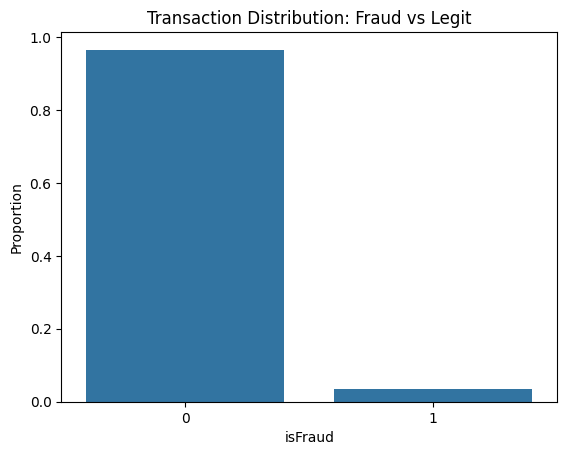

In [ ]:
### EDA
# fraud vs legit
fraud_counts = transaction['isFraud'].value_counts(normalize=True)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Transaction Distribution: Fraud vs Legit")
plt.xlabel("isFraud")
plt.ylabel("Proportion")
plt.show()

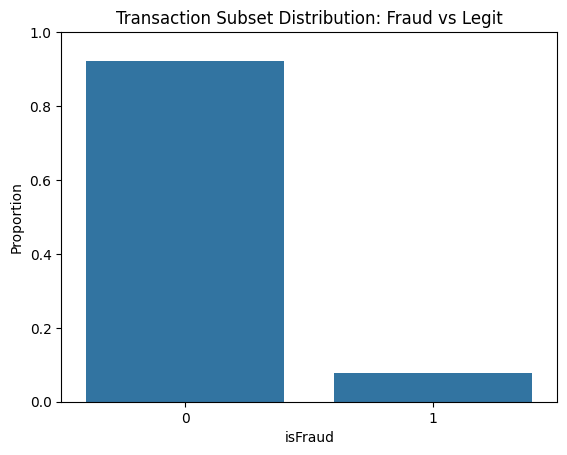

In [ ]:
fraud_counts = merged_df['isFraud'].value_counts(normalize=True)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Transaction Subset Distribution: Fraud vs Legit")
plt.xlabel("isFraud")
plt.ylabel("Proportion")
plt.ylim(0,1)
plt.show()

### Column Analysis

In [ ]:
def analyze_unknown_columns(df):
    """
    column analysis function translated from R
    """
    analysis_data = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Basic info
        col_type = col_data.dtype
        na_percent = round(col_data.isna().mean() * 100, 2)
        unique_values = col_data.nunique()
        
        # Min/Max for numeric columns
        if np.issubdtype(col_type, np.number):
            if col_data.notna().any():
                min_val = round(col_data.min(), 2)
                max_val = round(col_data.max(), 2)
            else:
                min_val = "All NA"
                max_val = "All NA"
        else:
            min_val = "N/A"
            max_val = "N/A"
        
        # Sample values (first 5 non-null unique values)
        sample_vals = col_data.dropna().unique()[:5]
        sample_str = ", ".join(str(x) for x in sample_vals)
        
        analysis_data.append({
            'column': col,
            'type': col_type,
            'na_percent': na_percent,
            'unique_values': unique_values,
            'min_value': min_val,
            'max_value': max_val,
            'sample_values': sample_str
        })
    
    # Create analysis DataFrame
    column_analysis = pd.DataFrame(analysis_data)
    
    print("=== AUTOMATED COLUMN ANALYSIS ===")
    pd.set_option('display.max_rows', None)
    print(column_analysis)
    pd.reset_option('display.max_rows')
    
    return column_analysis

#### Transaction

In [ ]:
column_info = analyze_unknown_columns(transaction)

=== AUTOMATED COLUMN ANALYSIS ===
             column     type  na_percent  unique_values min_value  max_value  \
0     TransactionID    int64        0.00         590540   2987000    3577539   
1           isFraud    int64        0.00              2         0          1   
2     TransactionDT    int64        0.00         573349     86400   15811131   
3    TransactionAmt  float64        0.00          20902      0.25   31937.39   
4         ProductCD   object        0.00              5       N/A        N/A   
5             card1    int64        0.00          13553      1000      18396   
6             card2  float64        1.51            500     100.0      600.0   
7             card3  float64        0.27            114     100.0      231.0   
8             card4   object        0.27              4       N/A        N/A   
9             card5  float64        0.72            119     100.0      237.0   
10            card6   object        0.27              4       N/A        N/A   
11    

#### Identity

In [ ]:
column_info = analyze_unknown_columns(identity)

=== AUTOMATED COLUMN ANALYSIS ===
           column     type  na_percent  unique_values min_value max_value  \
0   TransactionID    int64        0.00         144233   2987004   3577534   
1           id_01  float64        0.00             77    -100.0       0.0   
2           id_02  float64        2.33         115655       1.0  999595.0   
3           id_03  float64       54.02             24     -13.0      10.0   
4           id_04  float64       54.02             15     -28.0       0.0   
5           id_05  float64        5.11             93     -72.0      52.0   
6           id_06  float64        5.11            101    -100.0       0.0   
7           id_07  float64       96.43             84     -46.0      61.0   
8           id_08  float64       96.43             94    -100.0       0.0   
9           id_09  float64       48.05             46     -36.0      25.0   
10          id_10  float64       48.05             62    -100.0       0.0   
11          id_11  float64        2.26    